In [4]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.random import multivariate_normal
from chainconsumer import ChainConsumer
import matplotlib
import math

# Datasets and Models

### SN Ia

In [5]:
z_sn, m_obs, dm_obs_stat = np.loadtxt("SCPUnion2.1_mu_vs_z.dat", unpack=True)
dm_syst = 0.0169
dm_obs = np.sqrt(dm_syst + dm_obs_stat ** 2)

In [7]:
def luminosity_integrand(z, omgM):
    Ez = np.sqrt(omgM * np.power(1 + z, 3) + ((1-omgM)*(1-math.tanh(np.log10(1+z)))))
    return 1. / Ez

def luminosity_distance(z, h, omgM):
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, h, omgM):
    return 5. * np.log10(luminosity_distance(z, h, omgM)) + 25.

In [8]:
def chisq_sn(h, omgM):
    m_model = np.array([distance_modulus(z, h, omgM) for z in z_sn])
    chisq_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return chisq_vec.sum()


### CMB (first peak)

In [43]:
theta = 1.04085
err_theta = 0.00047
r_star = 144.61
z_star =  1090.09
c = 3000

In [45]:
def E_inverse(z,omgM):
    Ez = np.sqrt(omgM * np.power(1 + z, 3) + ((1-omgM)*(1-math.tanh(np.log10(1+z)))))
    return 1/Ez
    
def d_A(omgM):
    I,_ = quad(E_inverse, 0, z_star, args=(omgM))
    return I

#print(d_A(0.3))
def theta_modell(om,h):
    
    theta = (r_star*h)/(c*(d_A(om)))
    a=100*theta
    return a

#print(theta_modell(0.3,0.7))

def chisq_first_CMB(om,h):
    chisq = ( np.power( (theta_modell(om,h) - theta) / err_theta, 2 ) )
    return chisq

#print(chisq_first_CMB(0.3,0.7))

### CMB ( perturbation)

In [12]:
omgMh2_cmb = 0.1426
omgMh2_cmb_error = 0.0020

In [13]:
def chisq_cmb2(omgM,h):
    omgMh2_cmb_model = omgM*(h**2)
    chisq = np.power( (omgMh2_cmb_model - omgMh2_cmb) / omgMh2_cmb_error, 2 )
    return chisq



### Riess 2019

In [14]:
H0_Riess = 73.24
H0_Riess_error = 1.74


In [15]:
def chisq_Riess(h):
    H0_Riess_model = 100*h
    chisq = np.power( (H0_Riess_model - H0_Riess) / H0_Riess_error, 2 )
    return chisq


### SGL

In [16]:
z_l, z_s, D_obs,err_D = np.loadtxt("sgl.dat", unpack=True)

In [18]:
def Ez(z, omgM):
    Ez = np.sqrt(omgM * np.power(1 + z, 3) + ((1-omgM)*(1-math.tanh(np.log10(1+z)))))
    return Ez


def D_ls(z1,z2,om):
    integral, _ = quad(Ez, z1, z2, epsrel=1e-8, args=(om))
    return integral

def D_s(z,om):
    integral, _ = quad(Ez, 0, z, epsrel=1e-8, args=(om))
    return integral
    
def D_A(z,z1,z2,om):
    D = D_ls(z1,z2,om)/D_s(z,om)
    return D


In [21]:
h_fid = 0.73
omgB_fid = 0.05
omgG_fid = 5e-5
omgM_fid = 0.3

### SN Ia + $\Omega_m h^2$

In [19]:
def chisq_sn_om(pars):
    h, omgM = pars
    return chisq_cmb2(omgM,h) + chisq_sn(h, omgM)

In [22]:
result_sn_om = minimize(chisq_sn_om, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_om, omgM_sn_om = result_sn_om.x


In [23]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_om(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_om([h, omgM])

def lnprob_sn_om(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_om(pars)

In [32]:
ndim, nwalkers, nsteps = 2, 20, 300
pos = [[h_sn_om, omgM_sn_om] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_om, threads=4)
sampler1.run_mcmc(pos, nsteps)

test_chain1 = sampler1.flatchain

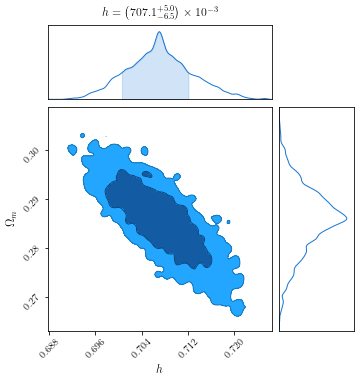

In [33]:
c = ChainConsumer()
plot_test_chain1 = [test_chain1[:,0], test_chain1[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain1, parameters=labels, name="SNIa+CMP(perturbation)")

#c.configure(legend_artists=True)
fig = c.plotter.plot()
fig.set_size_inches(2 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
#matplotlib.pyplot.savefig('plt.png', dpi=520, format='png', bbox_inches='tight')

### SN Ia + $\Omega_mh^2$ + CMB(first peak)

In [46]:
def chisq_sn_cmb(pars):
    h, omgM = pars
    return chisq_first_CMB(omgM,h) + chisq_sn(h, omgM) + chisq_cmb2(omgM,h)

In [47]:
result_sn_cmb = minimize(chisq_sn_cmb, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb, omgM_sn_cmb = result_sn_cmb.x

In [48]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb([h, omgM])

def lnprob_sn_cmb(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb(pars)



In [49]:
ndim, nwalkers, nsteps = 2, 20, 200
pos = [[h_sn_cmb, omgM_sn_cmb] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb, threads=4)
sampler3.run_mcmc(pos, nsteps)
test_chain3 = sampler3.flatchain

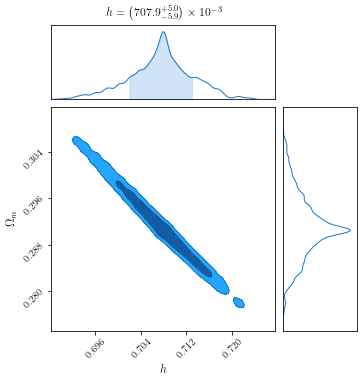

In [51]:
c = ChainConsumer()
plot_test_chain3 = [test_chain3[:,0], test_chain3[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain3, parameters=labels, name="SNIa+CMB(first peak and perturbation)")

fig = c.plotter.plot()
fig.set_size_inches(2 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

### SN Ia + $\Omega_mh^2$ + Riess 2019

In [52]:
def chisq_sn_cmb_R19(pars):
    h, omgM = pars
    return chisq_sn(h, omgM) + chisq_Riess(h) 

In [53]:
result_sn_cmb_R19 = minimize(chisq_sn_cmb_R19, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb_R19, omgM_sn_cmb_R19 = result_sn_cmb_R19.x

In [54]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb_R19(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb_R19([h, omgM])

def lnprob_sn_cmb_R19(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb_R19(pars)

In [55]:
ndim, nwalkers, nsteps = 2, 50, 1500
pos = [[h_sn_cmb_R19, omgM_sn_cmb_R19] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler4 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb_R19, threads=4)
sampler4.run_mcmc(pos, nsteps)

test_chain4 = sampler4.flatchain

emcee: Exception while calling your likelihood function:
  params: [0.70244021 0.30037085]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 542, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-54-de4df87e4730>", line 15, in lnprob_sn_cmb_R19
    return lp + lnlike_sn_cmb_R19(pars)
  File "<ipython-input-54-de4df87e4730>", line 9, in lnlike_sn_cmb_R19
    return -0.5 * chisq_sn_cmb_R19([h, omgM])
  File "<ipython-input-52-0bd74fe10f58>", line 3, in chisq_sn_cmb_R19
    return chisq_sn(h, omgM) + chisq_Riess(h)
  File "<ipython-input-8-472eb250bc97>", line 2, in chisq_sn
    m_model = np.array([distance_modulus(z, h, omgM) for z in z_sn])
  File "<ipython-input-8-472eb250bc97>", line 2, in <listcomp>
    m_model = np.array([distance_modulus(z, h, omgM) for z in z_sn])
  File "<ipython-input-7-d96e9ec0d4bb>", line 10, in distance_modulus
    return 5. * np.log10(luminosity_distance(z, h, omgM)) + 25.
  File "<ipython-input-7-d96e9ec0d4bb>", line 6, in luminosity_distance
    integra

KeyboardInterrupt: 

In [ ]:
plot_test_chain4 = [test_chain4[:,0], test_chain4[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain4, parameters=labels, name="SNIa+CMB+Riess2019")

#fig = c4.plotter.plot()

### SN Ia + $\Omega_mh^2$ + CMB+SGL


In [ ]:
def chisq_sn_cmb_sgl(pars):
    h, omgM = pars
    return chisq_sn(h, omgM) + chisq_cmb2(omgM,h)  + chisq_sgl(omgM,h)

In [ ]:
result_sn_cmb_sgl = minimize(chisq_sn_cmb_sgl, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb_sgl, omgM_sn_cmb_sgl = result_sn_cmb_sgl.x

In [ ]:
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb_sgl(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb_sgl([h, omgM])

def lnprob_sn_cmb_sgl(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb_sgl(pars)

In [ ]:
ndim, nwalkers, nsteps = 2, 20, 800
pos = [[h_sn_cmb_sgl, omgM_sn_cmb_sgl] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler5 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb_sgl, threads=4)
sampler5.run_mcmc(pos, nsteps)

test_chain5 = sampler5.flatchain

In [ ]:
plot_test_chain5 = [test_chain5[:,0], test_chain5[:,1]]
labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain5, parameters=labels, name="SNIa+CMB+SGL")

In [ ]:
c = ChainConsumer()
plot_test_chain1 = [test_chain1[:,0], test_chain1[:,1]]
plot_test_chain3 = [test_chain3[:,0], test_chain3[:,1]]
plot_test_chain4 = [test_chain4[:,0], test_chain4[:,1]]
plot_test_chain5 = [test_chain5[:,0], test_chain5[:,1]]

labels = [r"$h$",r"$\Omega_m$"]
c.add_chain(plot_test_chain1, parameters=labels, name="SNIa+CMB(perturbation)")
c.add_chain(plot_test_chain3, parameters=labels, name="SNIa+CMB(first peak and perturbation)")
c.add_chain(plot_test_chain4, parameters=labels, name="SNIa+Riess2019")
c.add_chain(plot_test_chain5, parameters=labels, name="SNIa+CMB+SGL")

c.configure(legend_artists=True)
fig = c.plotter.plot()
fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
matplotlib.pyplot.savefig('final2.png', dpi=520, format='png', bbox_inches='tight')